# Predicción de Demanda Energética de un Centro Educativo

En este Jupyter Notebook se realzan todos el ciclo de vida del preprocesamiento de los datos en crudo por tal de formar tres datasets diferentes: entrenamiento, validación y test. 


### Librerías

In [651]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

parameters = {
    "paths": {
        "meteo": "../data/barcelona_meteo.csv",
        "demand": "../data/CE_EO_Demanda.xlsx"
    }
}

### Datasets Iniciales

In [652]:
#Electricity Demand Dataset
demand_df = pd.read_excel(parameters["paths"]["demand"], sheet_name="Demanda")
demand_df["Date"] = pd.to_datetime(demand_df["Date"])
demand_df = demand_df.rename(columns={'Demanda': 'Demand'})
print(f"Demand Dataset, Nº of rows: {demand_df.shape[0]}")
display(demand_df.head(5))

#Meteorological Information Dataset
meteo_df = pd.read_csv(parameters["paths"]["meteo"])
meteo_df = meteo_df.rename(columns={'date': 'Date'})
meteo_df["Date"] = pd.to_datetime(meteo_df["Date"], format='%m/%d/%y %H:%M')
print(f"Meteo Dataset Nº of rows: {meteo_df.shape[0]}")
display(meteo_df.head(5))

Demand Dataset, Nº of rows: 70080


,Date,Demanda
0,2018-01-01 00:15:00,8
1,2018-01-01 00:30:00,8
2,2018-01-01 00:45:00,8
3,2018-01-01 01:00:00,8
4,2018-01-01 01:15:00,8


Meteo Dataset Nº of rows: 29472


,Date,Temperatura,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation
0,2017-01-01 00:00:00,8.422492,83,0.0,0.0,0.0,0.0,0.0
1,2017-01-01 01:00:00,7.992492,81,0.0,0.0,0.0,0.0,0.0
2,2017-01-01 02:00:00,7.642492,79,0.0,0.0,0.0,0.0,0.0
3,2017-01-01 03:00:00,6.912492,79,0.0,0.0,0.0,0.0,0.0
4,2017-01-01 04:00:00,6.352492,81,0.0,0.0,0.0,0.0,0.0


In [653]:
#Prints the NaN Values per Column of a dataset
def checkNaNValues(df):
    return print(f"NaN Count per Column", df.isna().any(axis=1).sum())

#Checks if there is any missing time series
def checkMissingData(df, date_column):
    min_date = df[date_column].min()
    max_date = df[date_column].max()

    date_range = pd.date_range(start=min_date, end=max_date, freq='15min')
    missing_dates = date_range[~date_range.isin(df[date_column])]
    print(f"Number of Missing Values: {missing_dates.shape[0]}")
    return None if missing_dates.shape[0] == 0 else missing_dates

#Demand Dataset
print("Demand Dataset:")
checkNaNValues(demand_df)
missing_data = checkMissingData(demand_df, "Date")
print(" ")
#Meteo Dataset
#A resampling is performed in meteo dataset to obtain quarter-hour data
print("Meteo Dataset:")
checkNaNValues(meteo_df)
meteo_df.set_index('Date', inplace=True)
meteo_resampled_df = meteo_df.resample('15min').asfreq()
meteo_resampled_df.reset_index(inplace=True)
missing_meteo_data = checkMissingData(meteo_resampled_df, "Date")

Demand Dataset:
NaN Count per Column 0
Number of Missing Values: 0
 
Meteo Dataset:
NaN Count per Column 0
Number of Missing Values: 0


In [654]:
display(meteo_resampled_df)

,Date,Temperatura,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation
0,2017-01-01 00:00:00,8.422492,83.0,0.0,0.000000,0.0,0.0,0.0
1,2017-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 01:00:00,7.992492,81.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
117880,2020-05-12 22:00:00,16.682491,67.0,0.0,2.032979,0.0,0.0,0.0
117881,2020-05-12 22:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117882,2020-05-12 22:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117883,2020-05-12 22:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [655]:
#Performs Interpolation between rows of a dataset, according to the specified columns and interpolation method
def interpolateData(df, columns, method):
    interpolated_df = df.copy()
    for col in columns:
        interpolated_df[col] = interpolated_df[col].interpolate(method=method)
    return interpolated_df

#When resampling the meteo dataset, we need to perform interpolation to fill the dataset
columns2interpolate = meteo_resampled_df.columns.drop("Date")
df_meteo_interpolated = interpolateData(meteo_resampled_df, columns2interpolate, 'linear')
display(df_meteo_interpolated)

,Date,Temperatura,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation
0,2017-01-01 00:00:00,8.422492,83.0,0.0,0.000000,0.0,0.0,0.0
1,2017-01-01 00:15:00,8.314992,82.5,0.0,0.000000,0.0,0.0,0.0
2,2017-01-01 00:30:00,8.207492,82.0,0.0,0.000000,0.0,0.0,0.0
3,2017-01-01 00:45:00,8.099992,81.5,0.0,0.000000,0.0,0.0,0.0
4,2017-01-01 01:00:00,7.992492,81.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
117880,2020-05-12 22:00:00,16.682491,67.0,0.0,2.032979,0.0,0.0,0.0
117881,2020-05-12 22:15:00,16.672491,66.5,0.0,1.524734,0.0,0.0,0.0
117882,2020-05-12 22:30:00,16.662492,66.0,0.0,1.016489,0.0,0.0,0.0
117883,2020-05-12 22:45:00,16.652492,65.5,0.0,0.508245,0.0,0.0,0.0


In [656]:
#The date range of the meteo dataset is adjusted to the demand dataset
min_date = demand_df["Date"].min()
max_date = demand_df["Date"].max()
new_meteo = df_meteo_interpolated[df_meteo_interpolated["Date"].between(min_date, max_date)]
print(f"Demand Dataset Length: {demand_df.shape[0]}, Meteo Dataset Length: {new_meteo.shape[0]}")
display(new_meteo.head(10))

Demand Dataset Length: 70080, Meteo Dataset Length: 70080


,Date,Temperatura,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation
35041,2018-01-01 00:15:00,12.967492,60.50,0.0,0.0,0.0,0.0,0.0
35042,2018-01-01 00:30:00,12.972492,61.00,0.0,0.0,0.0,0.0,0.0
35043,2018-01-01 00:45:00,12.977492,61.50,0.0,0.0,0.0,0.0,0.0
35044,2018-01-01 01:00:00,12.982492,62.00,0.0,0.0,0.0,0.0,0.0
35045,2018-01-01 01:15:00,12.709992,61.50,0.0,0.0,0.0,0.0,0.0
35046,2018-01-01 01:30:00,12.437492,61.00,0.0,0.0,0.0,0.0,0.0
35047,2018-01-01 01:45:00,12.164992,60.50,0.0,0.0,0.0,0.0,0.0
35048,2018-01-01 02:00:00,11.892492,60.00,0.0,0.0,0.0,0.0,0.0
35049,2018-01-01 02:15:00,11.567492,59.75,0.0,0.0,0.0,0.0,0.0
35050,2018-01-01 02:30:00,11.242492,59.50,0.0,0.0,0.0,0.0,0.0


In [623]:
#Outliers
def getNumberOfOutliersPerColumn(df, columns_list):
    for col in columns_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        #Calcular los límites inferiores y superiores para identificar outliers
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr

        outliers = ((df[col] < lim_inf) | (df[col] > lim_sup))
        #print(outliers.index[outliers])
        print(f"For {col} Column, the Number of Outliers is {outliers.sum()}\n")

getNumberOfOutliersPerColumn(df_meteo_interpolated, columns2interpolate)

For Temperatura Column, the Number of Outliers is 0

For Relative_Humidity Column, the Number of Outliers is 761

For Precipitation_Total Column, the Number of Outliers is 8572

For Sunshine_Duration Column, the Number of Outliers is 0

For Shortwave_Radiation Column, the Number of Outliers is 376

For Direct_Shortwave_Radiation Column, the Number of Outliers is 5240

For Diffuse_Shortwave_Radiation Column, the Number of Outliers is 0



In [624]:
demand_df["Year"] = demand_df["Date"].dt.year
demand_df["Month"] = demand_df["Date"].dt.month
demand_df["Hour"] = demand_df["Date"].dt.hour
demand_df["DayOfWeek"] = demand_df["Date"].dt.day_of_week
demand_df["DayOfYear"] = demand_df["Date"].dt.day_of_year

display(demand_df.head(10))

,Date,Demanda,Year,Month,Hour,DayOfWeek,DayOfYear
0,2018-01-01 00:15:00,8,2018,1,0,0,1
1,2018-01-01 00:30:00,8,2018,1,0,0,1
2,2018-01-01 00:45:00,8,2018,1,0,0,1
3,2018-01-01 01:00:00,8,2018,1,1,0,1
4,2018-01-01 01:15:00,8,2018,1,1,0,1
5,2018-01-01 01:30:00,8,2018,1,1,0,1
6,2018-01-01 01:45:00,12,2018,1,1,0,1
7,2018-01-01 02:00:00,8,2018,1,2,0,1
8,2018-01-01 02:15:00,8,2018,1,2,0,1
9,2018-01-01 02:30:00,8,2018,1,2,0,1


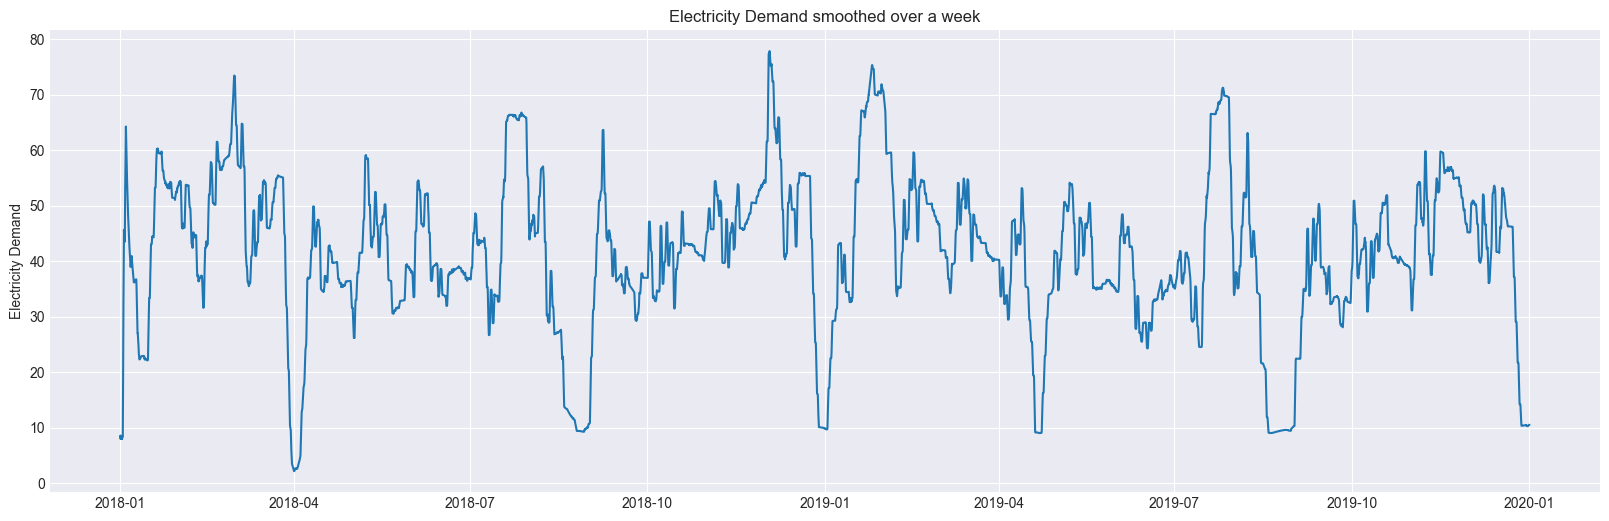

In [625]:
demand_df.index = pd.DatetimeIndex(demand_df["Date"])
demand_df = demand_df.sort_index()
plt.figure(figsize=(20, 6))
plt.ylabel("Electricity Demand")
plt.title("Electricity Demand smoothed over a week")
plt.plot(demand_df['Demand'].rolling(timedelta(days=7)).mean())
plt.show()

In [626]:
import plotly.graph_objects as go
demand_df_1w = demand_df.resample('1W').mean()
fig = go.Figure()
fig.add_trace(go.Scatter(x=demand_df_1w.index, y=demand_df_1w["Demand"], mode='lines'))
fig.update_layout(
    title = "Hourly Energy Demand",
    xaxis_title = "Date",
    yaxis_title = "Demand (MWh)",
    width = 850,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [627]:
start_date = demand_df['Date'].min()
end_date = start_date + timedelta(days=31)
df_month1 = demand_df.loc[(demand_df['Date'] >= start_date) & (demand_df['Date'] <= end_date)]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_month1.index, y=df_month1["Demand"], mode='lines'))
fig.update_layout(
    title = "One Week Energy Demand",
    xaxis_title = "Date",
    yaxis_title = "Demand (MWh)",
    width = 850,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

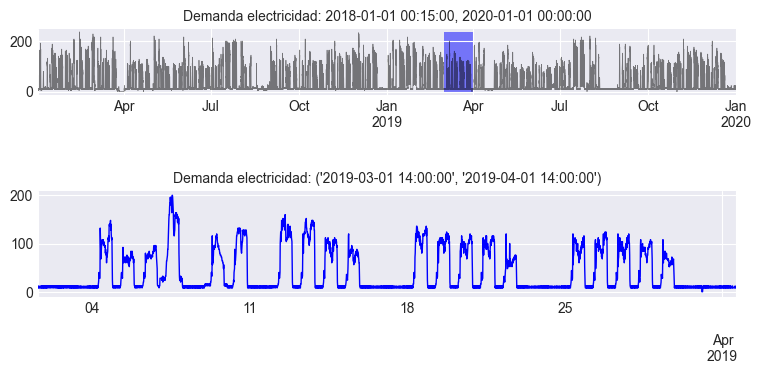

In [628]:
#Gráfico serie temporal con zoom
zoom = ('2019-03-01 14:00:00','2019-04-01 14:00:00')
fig = plt.figure(figsize=(9, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])
demand_df.Demand.plot(ax=main_ax, c="black", alpha=0.5, linewidth=0.5)
min_y = min(demand_df.Demand)
max_y = max(demand_df.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
demand_df.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Electricity Demand: {demand_df.index.min()}, {demand_df.index.max()}', fontsize=10)
zoom_ax.set_title(f'Electricity Demand: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

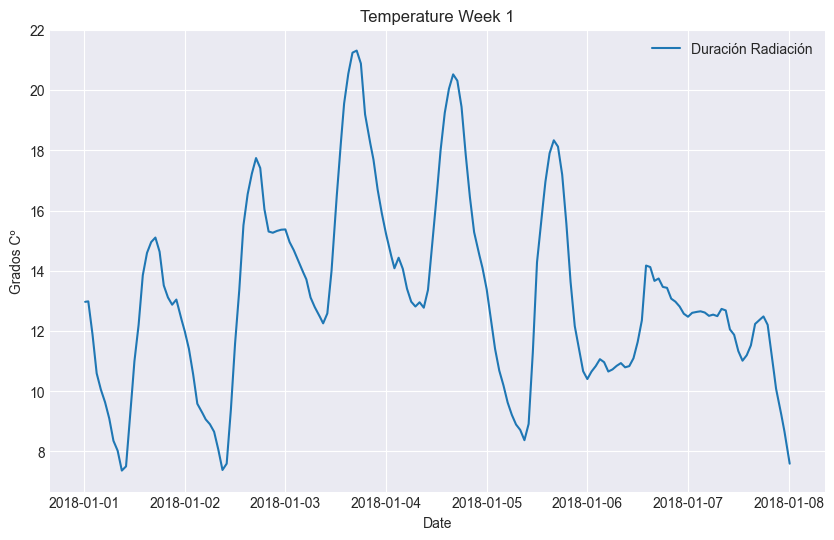

In [629]:
end_date = start_date + timedelta(days=7)
df_week1_temp = df_meteo_interpolated.loc[(df_meteo_interpolated['Date'] >= start_date) & (df_meteo_interpolated['Date'] <= end_date)]
plt.figure(figsize=(10, 6))
plt.plot(df_week1_temp["Date"], df_week1_temp['Temperatura'], label='Duración Radiación')
plt.title('Temperature Week 1')
plt.xlabel('Date')
plt.ylabel('Grados Cº')
plt.legend()

plt.show()

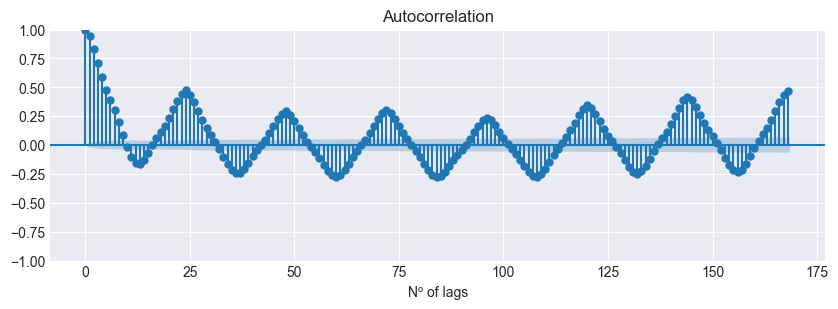

In [630]:
#Gráfico de autocorrelación 1
demand_df_1h = demand_df.resample('1h').mean()
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº of lags")
plot_acf(demand_df_1h.Demand, ax=ax, lags=24*7)
plt.show()

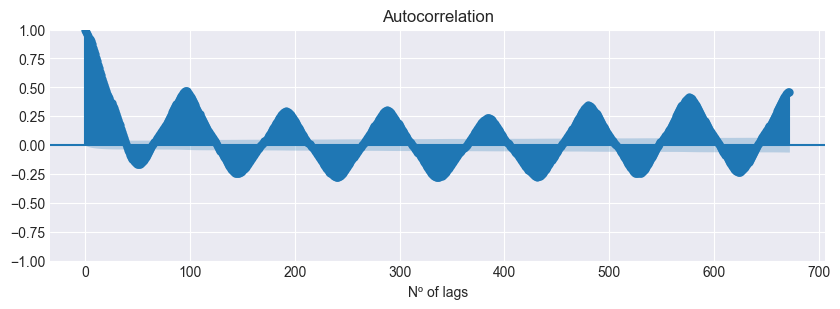

In [631]:
#Gráfico de autocorrelación 2
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº of lags")
plot_acf(demand_df.Demand, ax=ax, lags=96*7)
plt.show()

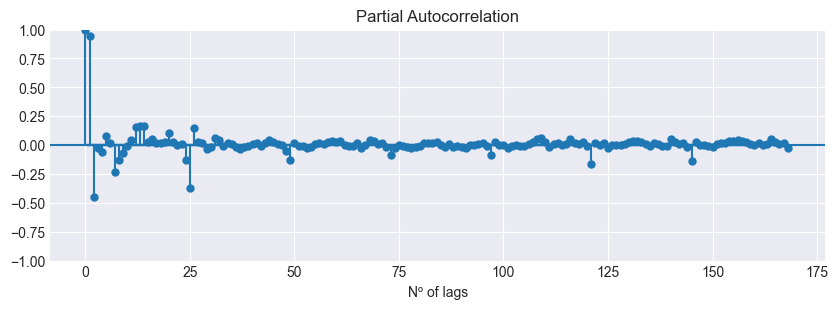

In [632]:
#Gráfico de autocorrelación parcial
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº of lags")
plot_pacf(demand_df_1h.Demand, ax=ax, lags=24*7)
plt.show()

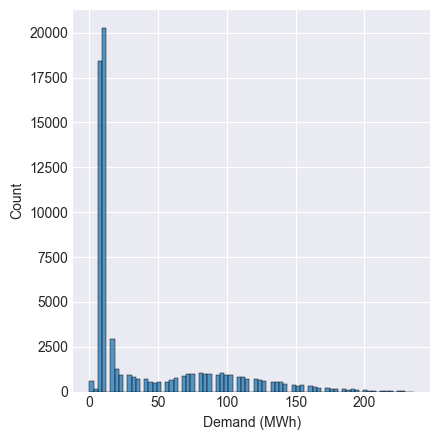

In [633]:
fg = sns.displot(demand_df['Demand'], height=4.5)
fg.set_axis_labels("Demand (MWh)", "Count")

In [634]:
display(demand_df.head(5))
demand_df.reset_index(drop=True, inplace=True)

,Date,Demanda,Year,Month,Hour,DayOfWeek,DayOfYear
Date,,,,,,,
2018-01-01 00:15:00,2018-01-01 00:15:00,8,2018,1,0,0,1
2018-01-01 00:30:00,2018-01-01 00:30:00,8,2018,1,0,0,1
2018-01-01 00:45:00,2018-01-01 00:45:00,8,2018,1,0,0,1
2018-01-01 01:00:00,2018-01-01 01:00:00,8,2018,1,1,0,1
2018-01-01 01:15:00,2018-01-01 01:15:00,8,2018,1,1,0,1


In [635]:
#Merge Demand Dataset and Meteo Dataset
whole_df = pd.merge(demand_df, df_meteo_interpolated, on='Date', how='inner')
display(whole_df.head(10))

,Date,Demanda,Year,Month,Hour,DayOfWeek,DayOfYear,Temperatura,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation
0,2018-01-01 00:15:00,8,2018,1,0,0,1,12.967492,60.50,0.0,0.0,0.0,0.0,0.0
1,2018-01-01 00:30:00,8,2018,1,0,0,1,12.972492,61.00,0.0,0.0,0.0,0.0,0.0
2,2018-01-01 00:45:00,8,2018,1,0,0,1,12.977492,61.50,0.0,0.0,0.0,0.0,0.0
3,2018-01-01 01:00:00,8,2018,1,1,0,1,12.982492,62.00,0.0,0.0,0.0,0.0,0.0
4,2018-01-01 01:15:00,8,2018,1,1,0,1,12.709992,61.50,0.0,0.0,0.0,0.0,0.0
5,2018-01-01 01:30:00,8,2018,1,1,0,1,12.437492,61.00,0.0,0.0,0.0,0.0,0.0
6,2018-01-01 01:45:00,12,2018,1,1,0,1,12.164992,60.50,0.0,0.0,0.0,0.0,0.0
7,2018-01-01 02:00:00,8,2018,1,2,0,1,11.892492,60.00,0.0,0.0,0.0,0.0,0.0
8,2018-01-01 02:15:00,8,2018,1,2,0,1,11.567492,59.75,0.0,0.0,0.0,0.0,0.0
9,2018-01-01 02:30:00,8,2018,1,2,0,1,11.242492,59.50,0.0,0.0,0.0,0.0,0.0


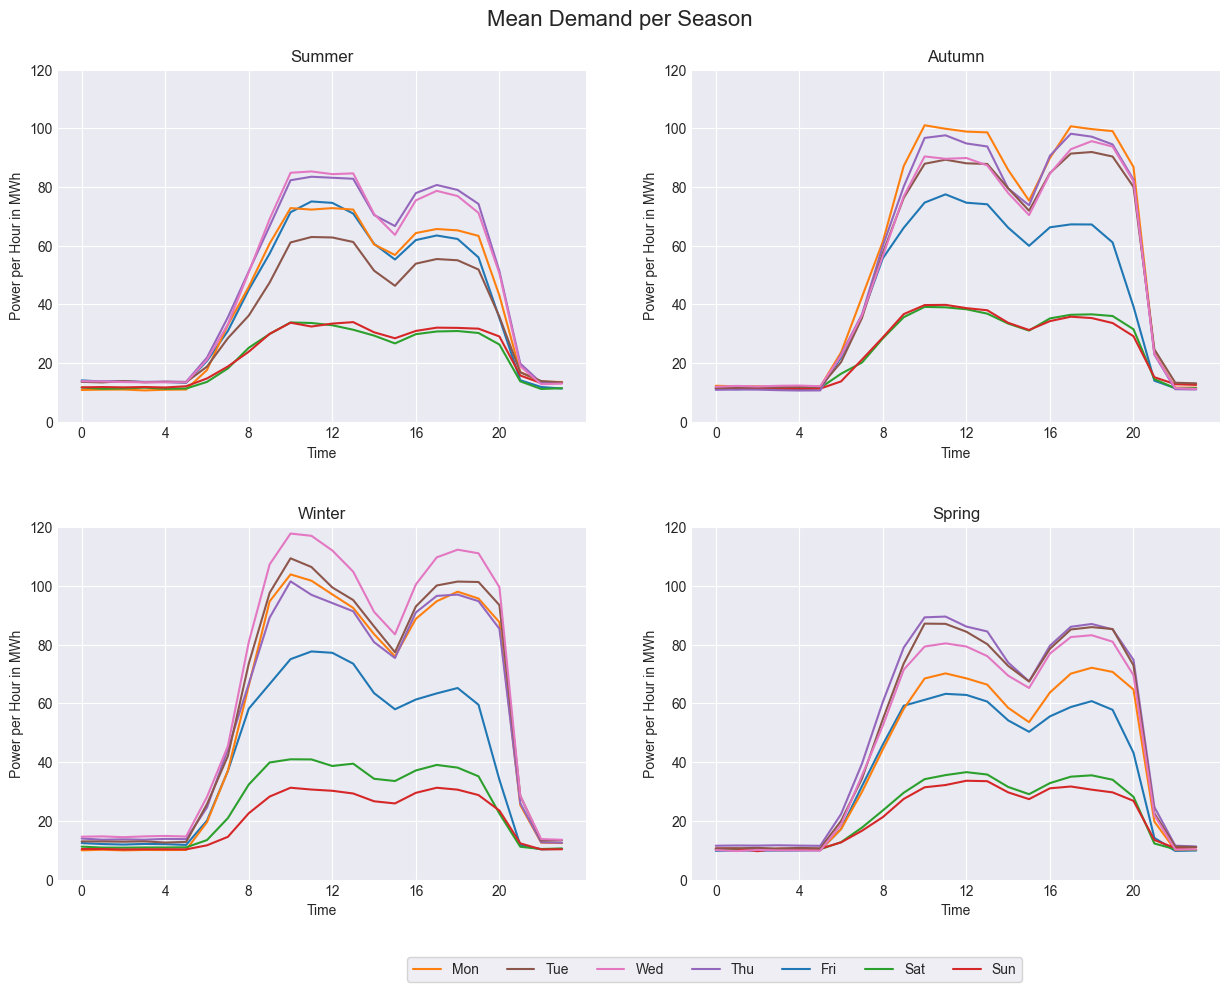

In [636]:
days_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
new_whole_df = whole_df.copy()
new_whole_df["Day"] = new_whole_df["DayOfWeek"].map(days_mapping)
new_whole_df["Season"] = new_whole_df["Month"].apply(
    lambda x: (
        'Spring' if x in [3, 4, 5]
        else 'Summer' if x in [6, 7, 8]
        else 'Autumn' if x in [9, 10, 11]
        else 'Winter'
    )
)
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.3, top=0.92)
fig.suptitle("Mean Demand per Season", fontsize=16)

fig.set_figheight(10)
fig.set_figwidth(15)

ymin, ymax = 0, 120

#Season Summer
new_whole_df.loc[new_whole_df["Season"] == "Summer"] \
    .groupby([new_whole_df.loc[new_whole_df["Season"] == "Summer"]["Hour"], 'Day'])["Demand"].mean().unstack().plot(
        ax=axes[0, 0], ylim=(ymin, ymax), title="Summer", legend=False
    )
new_whole_df.loc[new_whole_df["Season"] == "Autumn"] \
    .groupby([new_whole_df.loc[new_whole_df["Season"] == "Autumn"]["Hour"], 'Day'])["Demand"].mean().unstack().plot(
        ax=axes[0, 1], ylim=(ymin, ymax), title="Autumn", legend=False
    )
new_whole_df.loc[new_whole_df["Season"] == "Winter"] \
    .groupby([new_whole_df.loc[new_whole_df["Season"] == "Winter"]["Hour"], 'Day'])["Demand"].mean().unstack().plot(
        ax=axes[1, 0], ylim=(ymin, ymax), title="Winter", legend=False
    )
new_whole_df.loc[new_whole_df["Season"] == "Spring"] \
    .groupby([new_whole_df.loc[new_whole_df["Season"] == "Spring"]["Hour"], 'Day'])["Demand"].mean().unstack().plot(
        ax=axes[1, 1], ylim=(ymin, ymax), title="Spring", legend=False
    )

for ax in axes.flat:
    ax.set(xlabel='Time', ylabel='Power per Hour in MWh')

for n in range(0, 2):
    axes[n, 0].set_xticks([0, 4, 8, 12, 16, 20])
    axes[n, 1].set_xticks([0, 4, 8, 12, 16, 20])

# LEGEND
handles, labels = plt.gca().get_legend_handles_labels() # reorder Legend Labels
order = [1,5,6,4,0,2,3]      # specify order in Legend
axes[1,1].legend([handles[i] for i in order], [labels[i] for i in order], loc=1, ncol=7, 
                 bbox_to_anchor=(0.638,-0.2), frameon=True) # print and order LEGEND

Text(0.5, 0.98, '')

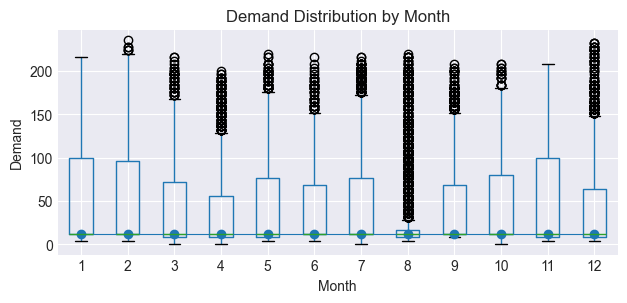

In [637]:

fig, ax = plt.subplots(figsize=(7, 3))
whole_df.boxplot(column='Demand', by='Month', ax=ax)
whole_df.groupby('Month')['Demand'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title("Demand Distribution by Month")
fig.suptitle('')


Text(0.5, 0.98, '')

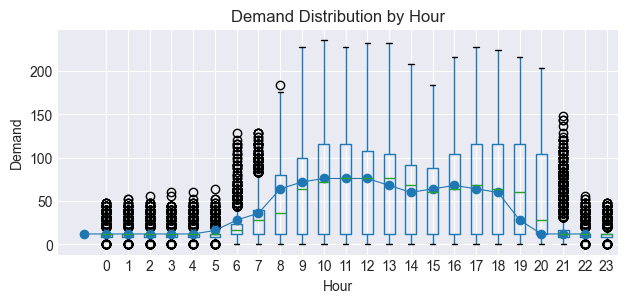

In [638]:
fig, ax = plt.subplots(figsize=(7, 3))
whole_df.boxplot(column='Demand', by='Hour', ax=ax)
whole_df.groupby('Hour')['Demand'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title("Demand Distribution by Hour")
fig.suptitle('')

In [639]:
#Generate a new column called h_sen, wich is the hour transformed by the sine function
def generateSinCosHour(df):
    df['Hour_sen'] = (np.pi * np.sin(df['Hour']) / 12)
    df['Hour_cos'] = (np.pi * np.cos(df["Hour"]) / 12)
    return df
whole_df["Demand_7d"] = whole_df["Demand"].shift(7 * 96).fillna(0)
whole_df["isWeekend"] = whole_df["DayOfWeek"].isin([5, 6])

whole_df = generateSinCosHour(whole_df)

In [640]:
display(whole_df.head(5))

,Date,Demanda,Year,Month,Hour,DayOfWeek,DayOfYear,Temperatura,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation,Demanda_7d,isWeekend,Hour_sen,Hour_cos
0,2018-01-01 00:15:00,8,2018,1,0,0,1,12.967492,60.5,0.0,0.0,0.0,0.0,0.0,0.0,False,0.000000,0.261799
1,2018-01-01 00:30:00,8,2018,1,0,0,1,12.972492,61.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.000000,0.261799
2,2018-01-01 00:45:00,8,2018,1,0,0,1,12.977492,61.5,0.0,0.0,0.0,0.0,0.0,0.0,False,0.000000,0.261799
3,2018-01-01 01:00:00,8,2018,1,1,0,1,12.982492,62.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.220297,0.141451
4,2018-01-01 01:15:00,8,2018,1,1,0,1,12.709992,61.5,0.0,0.0,0.0,0.0,0.0,0.0,False,0.220297,0.141451


In [641]:
def getDayBeforeDemand(df, row):
    date = row["Date"]
    counter, demand_24h = 0, 0
    if row.isWeekend:
        while counter < 7:
            date -= timedelta(days=1)
            row_24h = df.loc[df["Date"] == date]
            if not row_24h.empty:
                row_24h = row_24h.iloc[[0]].squeeze()
                if row_24h["isWeekend"]:
                    demand_24h = row_24h["Demand"]
                    break
            counter += 1
    else:
        while counter < 7:
            date -= timedelta(days=1)
            row_24h = df.loc[df["Date"] == date]
            if not row_24h.empty:
                row_24h = row_24h.iloc[[0]].squeeze()
                if row_24h["isWeekend"]:
                    demand_24h = row_24h["Demand"]
                    break
            counter += 1
    return demand_24h

whole_df["Demand_24h"] = whole_df.apply(
    lambda row: getDayBeforeDemand(whole_df, row), axis=1
)

In [642]:
import holidays
def generateHolidayVar(df):
    df["Reduced_Date"] = df["Date"].dt.date
    list_holidays = holidays.Spain(prov="CT", years=list(df["Year"].unique()))
    list_holidays_dates = np.array(list(list_holidays.keys()), dtype='datetime64')
    df["isHoliday"] = df["Reduced_Date"].isin(list_holidays_dates)
    df = df.drop('Reduced_Date', axis=1)
    return df
whole_df = generateHolidayVar(whole_df)
display(whole_df.head(5))

,Date,Demanda,Year,Month,Hour,DayOfWeek,DayOfYear,Temperatura,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation,Demanda_7d,isWeekend,Hour_sen,Hour_cos,Demanda_24h,isHoliday
0,2018-01-01 00:15:00,8,2018,1,0,0,1,12.967492,60.5,0.0,0.0,0.0,0.0,0.0,0.0,False,0.000000,0.261799,0,True
1,2018-01-01 00:30:00,8,2018,1,0,0,1,12.972492,61.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.000000,0.261799,0,True
2,2018-01-01 00:45:00,8,2018,1,0,0,1,12.977492,61.5,0.0,0.0,0.0,0.0,0.0,0.0,False,0.000000,0.261799,0,True
3,2018-01-01 01:00:00,8,2018,1,1,0,1,12.982492,62.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.220297,0.141451,0,True
4,2018-01-01 01:15:00,8,2018,1,1,0,1,12.709992,61.5,0.0,0.0,0.0,0.0,0.0,0.0,False,0.220297,0.141451,0,True


Text(0.5, 1.0, 'Pearson Correlation Matrix')

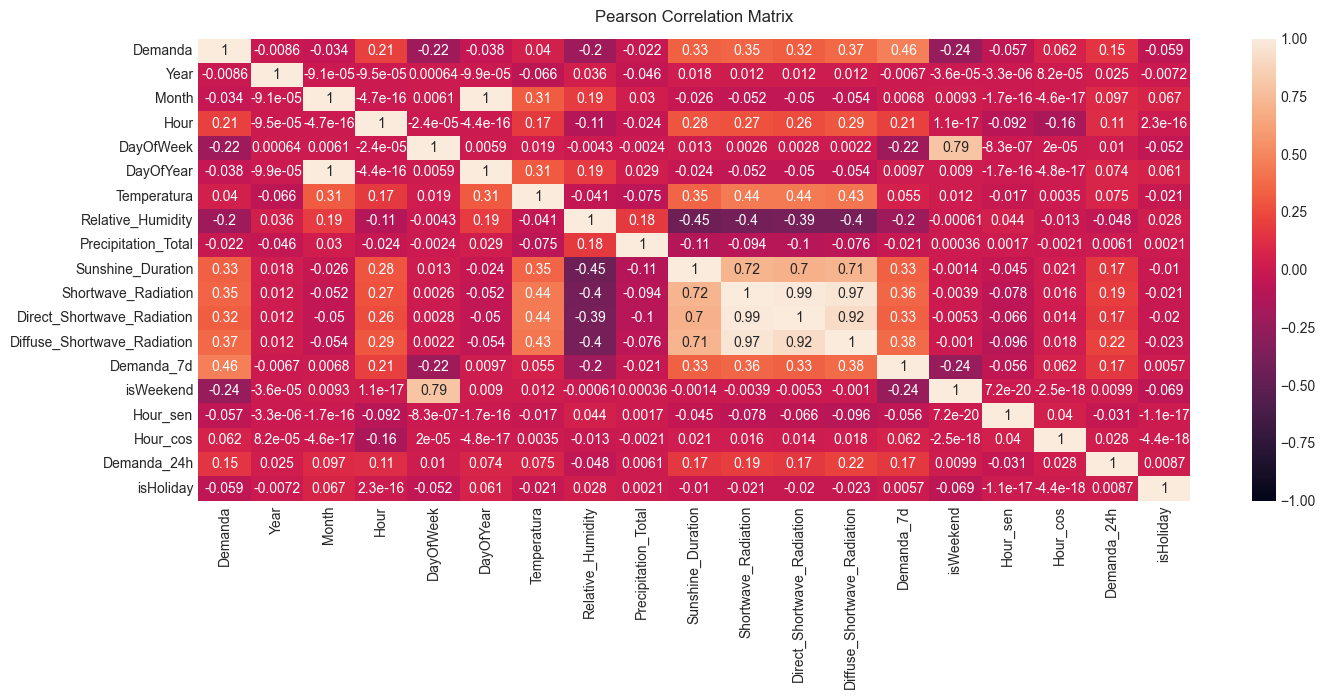

In [643]:
#Correlation Map using Pearson Correlation
plt.figure(figsize=(16,6))
corr_df = whole_df.copy()
#Drop Columns
corr_df = corr_df.drop(columns=["Date"])
heatmap = sns.heatmap(corr_df.corr('pearson'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Pearson Correlation Matrix', fontdict={'fontsize': 12}, pad=12)

In [644]:
display(whole_df.head(10))

,Date,Demanda,Year,Month,Hour,DayOfWeek,DayOfYear,Temperatura,Relative_Humidity,Precipitation_Total,Sunshine_Duration,Shortwave_Radiation,Direct_Shortwave_Radiation,Diffuse_Shortwave_Radiation,Demanda_7d,isWeekend,Hour_sen,Hour_cos,Demanda_24h,isHoliday
0,2018-01-01 00:15:00,8,2018,1,0,0,1,12.967492,60.50,0.0,0.0,0.0,0.0,0.0,0.0,False,0.000000,0.261799,0,True
1,2018-01-01 00:30:00,8,2018,1,0,0,1,12.972492,61.00,0.0,0.0,0.0,0.0,0.0,0.0,False,0.000000,0.261799,0,True
2,2018-01-01 00:45:00,8,2018,1,0,0,1,12.977492,61.50,0.0,0.0,0.0,0.0,0.0,0.0,False,0.000000,0.261799,0,True
3,2018-01-01 01:00:00,8,2018,1,1,0,1,12.982492,62.00,0.0,0.0,0.0,0.0,0.0,0.0,False,0.220297,0.141451,0,True
4,2018-01-01 01:15:00,8,2018,1,1,0,1,12.709992,61.50,0.0,0.0,0.0,0.0,0.0,0.0,False,0.220297,0.141451,0,True
5,2018-01-01 01:30:00,8,2018,1,1,0,1,12.437492,61.00,0.0,0.0,0.0,0.0,0.0,0.0,False,0.220297,0.141451,0,True
6,2018-01-01 01:45:00,12,2018,1,1,0,1,12.164992,60.50,0.0,0.0,0.0,0.0,0.0,0.0,False,0.220297,0.141451,0,True
7,2018-01-01 02:00:00,8,2018,1,2,0,1,11.892492,60.00,0.0,0.0,0.0,0.0,0.0,0.0,False,0.238054,-0.108947,0,True
8,2018-01-01 02:15:00,8,2018,1,2,0,1,11.567492,59.75,0.0,0.0,0.0,0.0,0.0,0.0,False,0.238054,-0.108947,0,True
9,2018-01-01 02:30:00,8,2018,1,2,0,1,11.242492,59.50,0.0,0.0,0.0,0.0,0.0,0.0,False,0.238054,-0.108947,0,True
